In [0]:
import numpy as np
import math
import keras
import sklearn.model_selection
from sklearn.metrics import r2_score
import os
import cv2
import matplotlib.pyplot
%matplotlib inline
from keras.models import model_from_json
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array
import random
import tensorflow as tf

In [0]:
# # set seed value for all random instances for reproducibility
# seed_value= 12321 
# os.environ['PYTHONHASHSEED']=str(0)
# random.seed(seed_value)
# np.random.seed(seed_value)
# tf.random.set_seed(seed_value)

In [563]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
measurementsDataSet = np.load("/content/drive/My Drive/Colab folder/weather_410.npy")

Mounted at /content/drive


In [564]:
print('Imported data shape: ' + str(measurementsDataSet.shape))

Imported data shape: (410, 4)


In [0]:
# split data into inputs and ouputs
imageNumbers, regularityMeasures, complexityMeasures, touchMeasures = np.hsplit(measurementsDataSet,4)

In [0]:
outputValues = np.hstack((regularityMeasures, complexityMeasures, touchMeasures))
outputValues = np.array(outputValues)

Text(0.5, 1.0, 'Image shape =(2560, 1440, 3)')

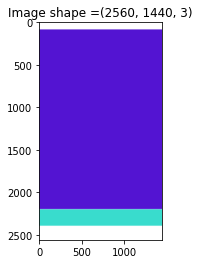

In [567]:
imageArray = cv2.imread(os.path.join("/content/drive/My Drive/Colab folder/weather_ann/", str(int(imageNumbers[0]))+'.png'))

matplotlib.pyplot.imshow(imageArray, cmap='gray')
matplotlib.pyplot.title('Image shape =' + str(imageArray.shape))

In [0]:
# create image data array from image numbers
imageResizeFactor = math.gcd(2560, 1440)/4 # HCF/GCD is 160 for annotated images
newImageDim1 = int(2560/imageResizeFactor)
newImageDim2 = int(1440/imageResizeFactor)
RGB = 3

# imageData = []
# #connect path to independent folders to image path
# for i in range(0, len(measurementsDataSet)):
#     # actual images are in jpg
#     imageArray = load_img(os.path.join("/content/drive/My Drive/Colab folder/weather_ann/", str(int(measurementsDataSet[i][0])) + ".png"), target_size = (newImageDim1,newImageDim2,RGB))
#     imageArray = img_to_array(imageArray)
#     imageData.append(imageArray/255)

imageData = []
#connect path to independent folders to image path
for imageIndex in imageNumbers:
    # semantic images are in png not jpg
    imageArray = cv2.imread(os.path.join("/content/drive/My Drive/Colab folder/weather_ann/", str(int(imageIndex))+'.png'))
    # resize if need to resize
    imageArray = cv2.resize(imageArray,(newImageDim2,newImageDim1)) # for some reason, will ask Farzaneh
    imageArray = imageArray.astype('float32')
    imageData.append(imageArray/255)


inputValues = np.array(imageData)

Text(0.5, 1.0, 'Image shape =(64, 36, 3)')

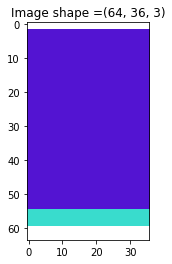

In [569]:
matplotlib.pyplot.imshow(inputValues[0], cmap='gray')
matplotlib.pyplot.title('Image shape =' + str(inputValues[0].shape))

In [570]:
# split into training and testing data
trainingDataX, testingDataX, trainingDataY, testingDataY = sklearn.model_selection.train_test_split(inputValues, 
                                                                                                    outputValues,
                                                                                                    test_size=0.3)
print(trainingDataX.shape)
print(trainingDataY.shape)
print(testingDataX.shape)
print(testingDataY.shape)

(287, 64, 36, 3)
(287, 3)
(123, 64, 36, 3)
(123, 3)


In [0]:
def buildCNNModel():
    inputLayer = keras.layers.Input(shape = (newImageDim1, newImageDim2, RGB))
    
    # first convolutional unit
    convolutionalLayer10 = keras.layers.Conv2D(64, 
                                              kernel_size=(3,3),
                                              activation='relu',
                                              input_shape=(newImageDim1, newImageDim2, RGB))(inputLayer)
    maxpoolingLayer10 = keras.layers.MaxPooling2D(pool_size=(2, 2))(convolutionalLayer10)
    
    # second convolutional unit
    convolutionalLayer20 = keras.layers.Conv2D(64,
                                              kernel_size=(3,3),
                                              activation='relu',
                                              input_shape=(newImageDim1, newImageDim2, RGB))(maxpoolingLayer10)
    maxpoolingLayer20 = keras.layers.MaxPooling2D(pool_size=(2, 2))(convolutionalLayer20)

    # third convolutional unit
    convolutionalLayer30 = keras.layers.Conv2D(64,
                                              kernel_size=(3,3),
                                              activation='relu',
                                              input_shape=(newImageDim1, newImageDim2, RGB))(maxpoolingLayer20)
    maxpoolingLayer30 = keras.layers.MaxPooling2D(pool_size=(2, 2))(convolutionalLayer30)
    
    # fork into three channels here    
    
    # fork into three channels here, this is first output(for regularity)
    flattenLayer11 = keras.layers.Flatten()(maxpoolingLayer30)
    denseLayer11 = keras.layers.Dense(216, activation='relu')(flattenLayer11)
    denseLayer21 = keras.layers.Dense(36, activation='relu')(denseLayer11)
    denseLayer31 = keras.layers.Dense(6, activation='relu')(denseLayer21)
    outputLayer1 = keras.layers.Dense(1, activation='sigmoid')(denseLayer31)
    
    # this is second output (for complexity)
    flattenLayer12 = keras.layers.Flatten()(maxpoolingLayer30)
    denseLayer12 = keras.layers.Dense(216, activation='relu')(flattenLayer12)
    denseLayer22 = keras.layers.Dense(36, activation='relu')(denseLayer12)
    denseLayer32 = keras.layers.Dense(6, activation='relu')(denseLayer22)
    outputLayer2 = keras.layers.Dense(1, activation='sigmoid')(denseLayer32)
    
    # this is third output (for touch)
    # fourth convolutional unit
    convolutionalLayer43 = keras.layers.Conv2D(64,
                                              kernel_size=(3,3),
                                              activation='relu',
                                              input_shape=(newImageDim1, newImageDim2, RGB))(maxpoolingLayer20)
    maxpoolingLayer43 = keras.layers.MaxPooling2D(pool_size=(2, 2))(convolutionalLayer43)
    
    flattenLayer13 = keras.layers.Flatten()(maxpoolingLayer43)
    denseLayer13 = keras.layers.Dense(216, activation='relu')(flattenLayer13)
    denseLayer23 = keras.layers.Dense(36, activation='relu')(denseLayer13)
    denseLayer33 = keras.layers.Dense(6, activation='relu')(denseLayer23)
    outputLayer3 = keras.layers.Dense(1, activation='tanh')(denseLayer33)
    
    # generate model from stucture
    model = keras.models.Model(inputLayer, [outputLayer1, outputLayer2, outputLayer3])
    
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mean_squared_error'])
    
    return model

In [572]:
trainingModel = buildCNNModel()
trainingModel.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 64, 36, 3)    0                                            
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 62, 34, 64)   1792        input_22[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_73 (MaxPooling2D) (None, 31, 17, 64)   0           conv2d_73[0][0]                  
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 29, 15, 64)   36928       max_pooling2d_73[0][0]           
___________________________________________________________________________________________

In [573]:
fitModel = trainingModel.fit(trainingDataX, 
                             [trainingDataY[:,0],
                             trainingDataY[:,1],
                             trainingDataY[:,2]],
                             epochs=30,
                            )

Epoch 1/30
287/287 [==============================] - 1s 3ms/step - loss: 0.1668 - dense_256_loss: 0.0456 - dense_260_loss: 0.0228 - dense_264_loss: 0.0981 - dense_256_mean_squared_error: 0.0457 - dense_260_mean_squared_error: 0.0229 - dense_264_mean_squared_error: 0.0983
Epoch 2/30
287/287 [==============================] - 0s 843us/step - loss: 0.0853 - dense_256_loss: 0.0154 - dense_260_loss: 0.0090 - dense_264_loss: 0.0609 - dense_256_mean_squared_error: 0.0154 - dense_260_mean_squared_error: 0.0090 - dense_264_mean_squared_error: 0.0609
Epoch 3/30
287/287 [==============================] - 0s 866us/step - loss: 0.0636 - dense_256_loss: 0.0129 - dense_260_loss: 0.0070 - dense_264_loss: 0.0436 - dense_256_mean_squared_error: 0.0129 - dense_260_mean_squared_error: 0.0070 - dense_264_mean_squared_error: 0.0438
Epoch 4/30
287/287 [==============================] - 0s 824us/step - loss: 0.0510 - dense_256_loss: 0.0114 - dense_260_loss: 0.0058 - dense_264_loss: 0.0338 - dense_256_mean_sq

In [574]:
# R-Square_training(Farzaneh)
RM_Training = sklearn.metrics.r2_score(trainingDataY[:,0], trainingModel.predict(trainingDataX)[0]) 
CM_Training = sklearn.metrics.r2_score(trainingDataY[:,1], trainingModel.predict(trainingDataX)[1]) 
TTM_Training = sklearn.metrics.r2_score(trainingDataY[:,2], trainingModel.predict(trainingDataX)[2]) 
print("R2 for RM_Training: "+ str(RM_Training ))
print("R2 for CM_Training: "+ str(CM_Training ))
print("R2 for TTM_Training: "+ str(TTM_Training ))

R2 for RM_Training: 0.9267530943815488
R2 for CM_Training: 0.9217254702478594
R2 for TTM_Training: 0.9830058545047748


In [575]:
# R-Square_Testing (Farzaneh)
RM_Testing = sklearn.metrics.r2_score(testingDataY[:,0], trainingModel.predict(testingDataX)[0]) 
CM_Testing = sklearn.metrics.r2_score(testingDataY[:,1], trainingModel.predict(testingDataX)[1]) 
TTM_Testing = sklearn.metrics.r2_score(testingDataY[:,2], trainingModel.predict(testingDataX)[2]) 
print("R2 for RM_Testing: "+ str(RM_Testing ))
print("R2 for CM_Testing: "+ str(CM_Testing ))
print("R2 for TTM_Testing: "+ str(TTM_Testing ))

R2 for RM_Testing: 0.885716805350318
R2 for CM_Testing: 0.8910978513644159
R2 for TTM_Testing: 0.8918224312200579


In [0]:
def makeModelPlot(plotType, fitModel):
    modelHistoryKeys = fitModel.history.keys()
    counter = 1
    matplotlib.pyplot.figure()
    for key in modelHistoryKeys:
        if key.endswith(plotType):
            matplotlib.pyplot.plot(fitModel.history[key],
            label=plotType+str(counter))
            counter = counter + 1
        else: continue
    matplotlib.pyplot.title('Model ' + plotType)
    matplotlib.pyplot.ylabel(plotType)
    matplotlib.pyplot.xlabel('Epoch')
    matplotlib.pyplot.legend()
    matplotlib.pyplot.show()

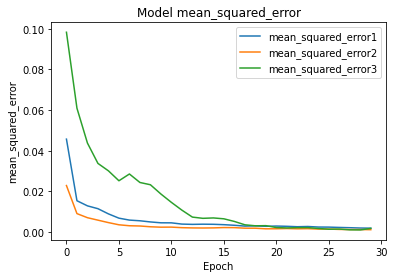

In [577]:
# check model accuracy 
# plot the accuracy per epoch
makeModelPlot('mean_squared_error',fitModel)
# plot loss per epoch
# makeModelPlot('loss',fitModel)

In [0]:
# def calculateR2ScoreTry1(trainingModel, dataX, dataY):
#     numberOfMetrics = dataY.shape[1]

#     print('Measurement 1 is Regularity, 2 is Complexity, and 3 is Touch.')
#     print('')
#     for i in range(numberOfMetrics):
#         predictedValues = []
#         actualValues = []
#         for counter in range(len(dataX)):
#             predictions = trainingModel.predict(dataX[counter].reshape(1,newImageDim1,newImageDim2,RGB))
#             predictions = np.array(predictions)
#             predictedValues.append(predictions[i][0][0])
#             actualValues.append(dataY[counter,i])
#         r2Score = r2_score(actualValues, predictedValues)
#         print('R2 score for measurement %.0f' % (i+1)+ ' is: %.3f' % (r2Score*100) + "%")

In [0]:
# def calculateR2ScoreTry2(trainingModel, dataX, dataY):
#     numberOfMetrics = dataY.shape[1]

#     print('Measurement 1 is Regularity, 2 is Complexity, and 3 is Touch.')
#     print('')
#     for i in range(numberOfMetrics):
#         predictions = trainingModel.predict(dataX)
#         actual = dataY[:,i]
#         r2Score = r2_score(actual, predictions[i])
#         print('R2 score for measurement %.0f' % (i+1)+ ' is: %.3f' % (r2Score*100) + "%")

In [0]:
# # R-Square_training(Jay)
# print('Try1')
# calculateR2ScoreTry1(trainingModel, trainingDataX, trainingDataY)

In [0]:
# print('Try2')
# calculateR2ScoreTry2(trainingModel, trainingDataX, trainingDataY)

In [586]:
# save model to JSON
model_json = trainingModel.to_json()
with open("model_888989.json", "w") as json_file:
    json_file.write(model_json)

# save weights to HDF5
# weights = model.get_weights()
# np.save("weights_array.npy", weights)
trainingModel.save_weights("model_888989.h5")
print("Saved model")

Saved model


In [587]:
# load json and create model
json_file = open('model_888989.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
weights = loaded_model.load_weights("model_888989.h5")
print("Loaded model")

Loaded model


(64, 36, 3)
Image index 144
This screenshot is predicted to have RM=  0.3278442 and it actually has RM =  0.22222
This screenshot is predicted to have CM=  0.62506914 and it actually has CM =  0.66667
This screenshot is predicted to have TTM=  0.06805917 and it actually has TTM =  0.0
57088.0


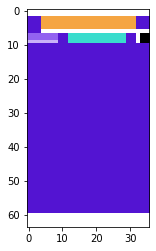

In [627]:
image_index = np.random.randint(0, len(imageData))
print(inputValues[image_index].shape)

matplotlib.pyplot.imshow(inputValues[image_index])

predRM = loaded_model.predict(inputValues[image_index].reshape(1,newImageDim1,newImageDim2,3))[0]
predCM = loaded_model.predict(inputValues[image_index].reshape(1,newImageDim1,newImageDim2,3))[1]
predTTM = loaded_model.predict(inputValues[image_index].reshape(1,newImageDim1,newImageDim2,3))[2]

print("Image index " + str(image_index))
print("This screenshot is predicted to have RM=  " + str(predRM[0][0]) + " and it actually has RM =  " + str(outputValues[:,0][image_index]))
print("This screenshot is predicted to have CM=  " + str(predCM[0][0]) + " and it actually has CM =  " + str(outputValues[:,1][image_index]))
print("This screenshot is predicted to have TTM=  " + str(predTTM[0][0]) + " and it actually has TTM =  " + str(outputValues[:,2][image_index]))

print(str(measurementsDataSet[image_index][0]))